# TP3

In [1]:
import src.data as data

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### **Question 1**
Displaying the distribution of genres as a bar plot.

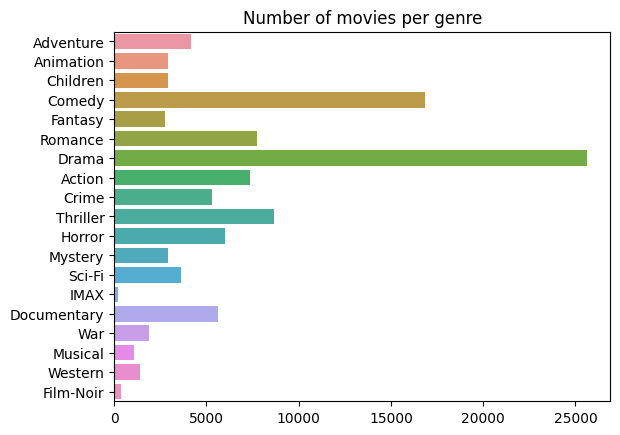

In [2]:
# Loading data
movies = data.load_movies()

# Counting occurences of each genre
genre_count = {}
for mov in movies.values:
    for genre in mov[2]:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1

# Ignoring '(no genres listed)' genre
genre_count.pop('(no genres listed)')

# Plotting
p = sns.barplot(y=list(genre_count.keys()), x=list(genre_count.values()), orient='h')
p.set_title('Number of movies per genre')
plt.show()

### **Question 2**
Creating two new data files `movies1.csv` and `ratings1.csv` containing only the movies that have a genre listed and the ratings for those movies.

In [3]:
# Creating movies1.csv
movies_with_genre_id = []
# Reading movies.csv
with open('data/movies.csv', 'r', encoding='utf-8') as f:
    lines = f.readlines()
with open('data/movies1.csv', 'w', encoding='utf-8') as f:
    for line in lines:
        if 'no genres listed' not in line:
            # Writing line to movies1.csv
            f.write(line)
            # Getting movie id
            movies_with_genre_id.append(line.split(',')[0])

In [4]:
# # Creating ratings1.csv (can take several minutes AND timeout because of notebooks usual weirsness)
# modified_ratings = {'5.5': '5', '5.0': '5', '4.5': '4', '4.0': '4', '3.5': '3', '3.0': '3', '2.5': '2', '2.0': '2', '1.5': '1', '1.0': '1', '0.5': '1', '0.0': '0'}
# # Reading ratings.csv
# with open('data/ratings.csv', 'r', encoding='utf-8') as f:
#     lines = f.readlines()
# with open('data/ratings1.csv', 'w', encoding='utf-8') as f:
#     f.write(lines[0])
#     for line in lines[1:]:
#         s = line.split(',')
#         if s[1] in movies_with_genre_id:
#             # Modifying the rating
#             s[2] = modified_ratings[s[2]]
#             # Writing line to ratings1.csv
#             f.write(','.join(s))

### **Question 3**
Building a binary matrix `movie_genre_matrix` where :

`movie_genre_matrix[i,j] = 1` if the movie `i` is of genre `j` and `movie_genre_matrix[i,j] = 0` otherwise.

In [5]:
movies_map, movie_genre_matrix = data.movies_stats()

### **Question 4**
Computing the profile vector of each user `u`, where the `k`-th coordinate of the profile vector of `u` is the sum of the ratings given by `u` to the movies of genre `k`.

The profiles are stored in a matrix `users_profiles` where the `k`-th row is the profile vector of the user `k`.

In [6]:
# Can take several minutes aswell

ratings = data.load_ratings_with_genre()
users_map, users_profiles, _ = data.users_stats(ratings, movie_genre_matrix, movies_map)

### **Question 5**

We start by normalizing the data between 0 and 1. It allow the clustering algorithm to run **thousands** of times faster.

In [7]:
max_ = 0
for u in range(len(users_profiles)):
    if np.max(users_profiles[u]) > max_:
        max_ = np.max(users_profiles[u])
users_profiles /= max_

Then we use the `spectral_clustering` function from `sklearn` to cluster the data and the `silhouette_score` function to compute the silhouette score of each clustering that we plot. We run the clustering algorithm for `k` between 2 and 5 to find the best `k`.

K = 2
	Cluster 0: 9858 users
	Cluster 1: 656 users
	Silhouette score for 2 clusters: 0.7784325933612091

K = 3
	Cluster 0: 9417 users
	Cluster 1: 2 users
	Cluster 2: 1095 users
	Silhouette score for 3 clusters: 0.734752818285339

K = 4
	Cluster 0: 9172 users
	Cluster 1: 2 users
	Cluster 2: 11 users
	Cluster 3: 1329 users
	Silhouette score for 4 clusters: 0.7130317727684725

K = 5
	Cluster 0: 9065 users
	Cluster 1: 2 users
	Cluster 2: 11 users
	Cluster 3: 782 users
	Cluster 4: 654 users
	Silhouette score for 5 clusters: 0.6709790700567609



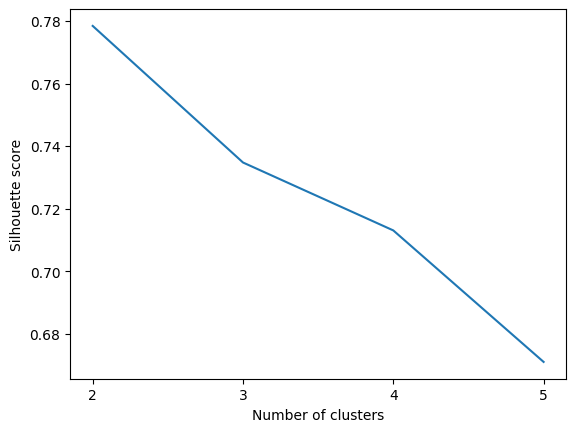

In [8]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score


silhouette_scores = []
labels = []

for k in range(2, 6):
    clustering = SpectralClustering(n_clusters=k, assign_labels="kmeans", n_jobs=-1).fit(users_profiles)
    # clustering = SpectralClustering(n_clusters=k, assign_labels="kmeans", n_jobs=-1, eigen_solver='lobpcg').fit(users_profiles)
    # clustering = SpectralClustering(n_clusters=k, assign_labels="kmeans", n_jobs=-1, eigen_solver='amg').fit(users_profiles)
    print(f'K = {k}')
    for i in range(k):
        print(f'\tCluster {i}: {np.sum(clustering.labels_ == i)} users')
    labels.append(clustering.labels_)
    silhouette_scores.append(silhouette_score(users_profiles, labels[-1]))
    print(f'\tSilhouette score for {k} clusters: {silhouette_scores[-1]}\n')

plt.plot(range(2, 6), silhouette_scores)
plt.xlabel('Number of clusters')
plt.xticks(range(2, 6))
plt.ylabel('Silhouette score')
plt.show()

Using UMAP to visualize the clusters in 2D.

C:\Users\LV\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


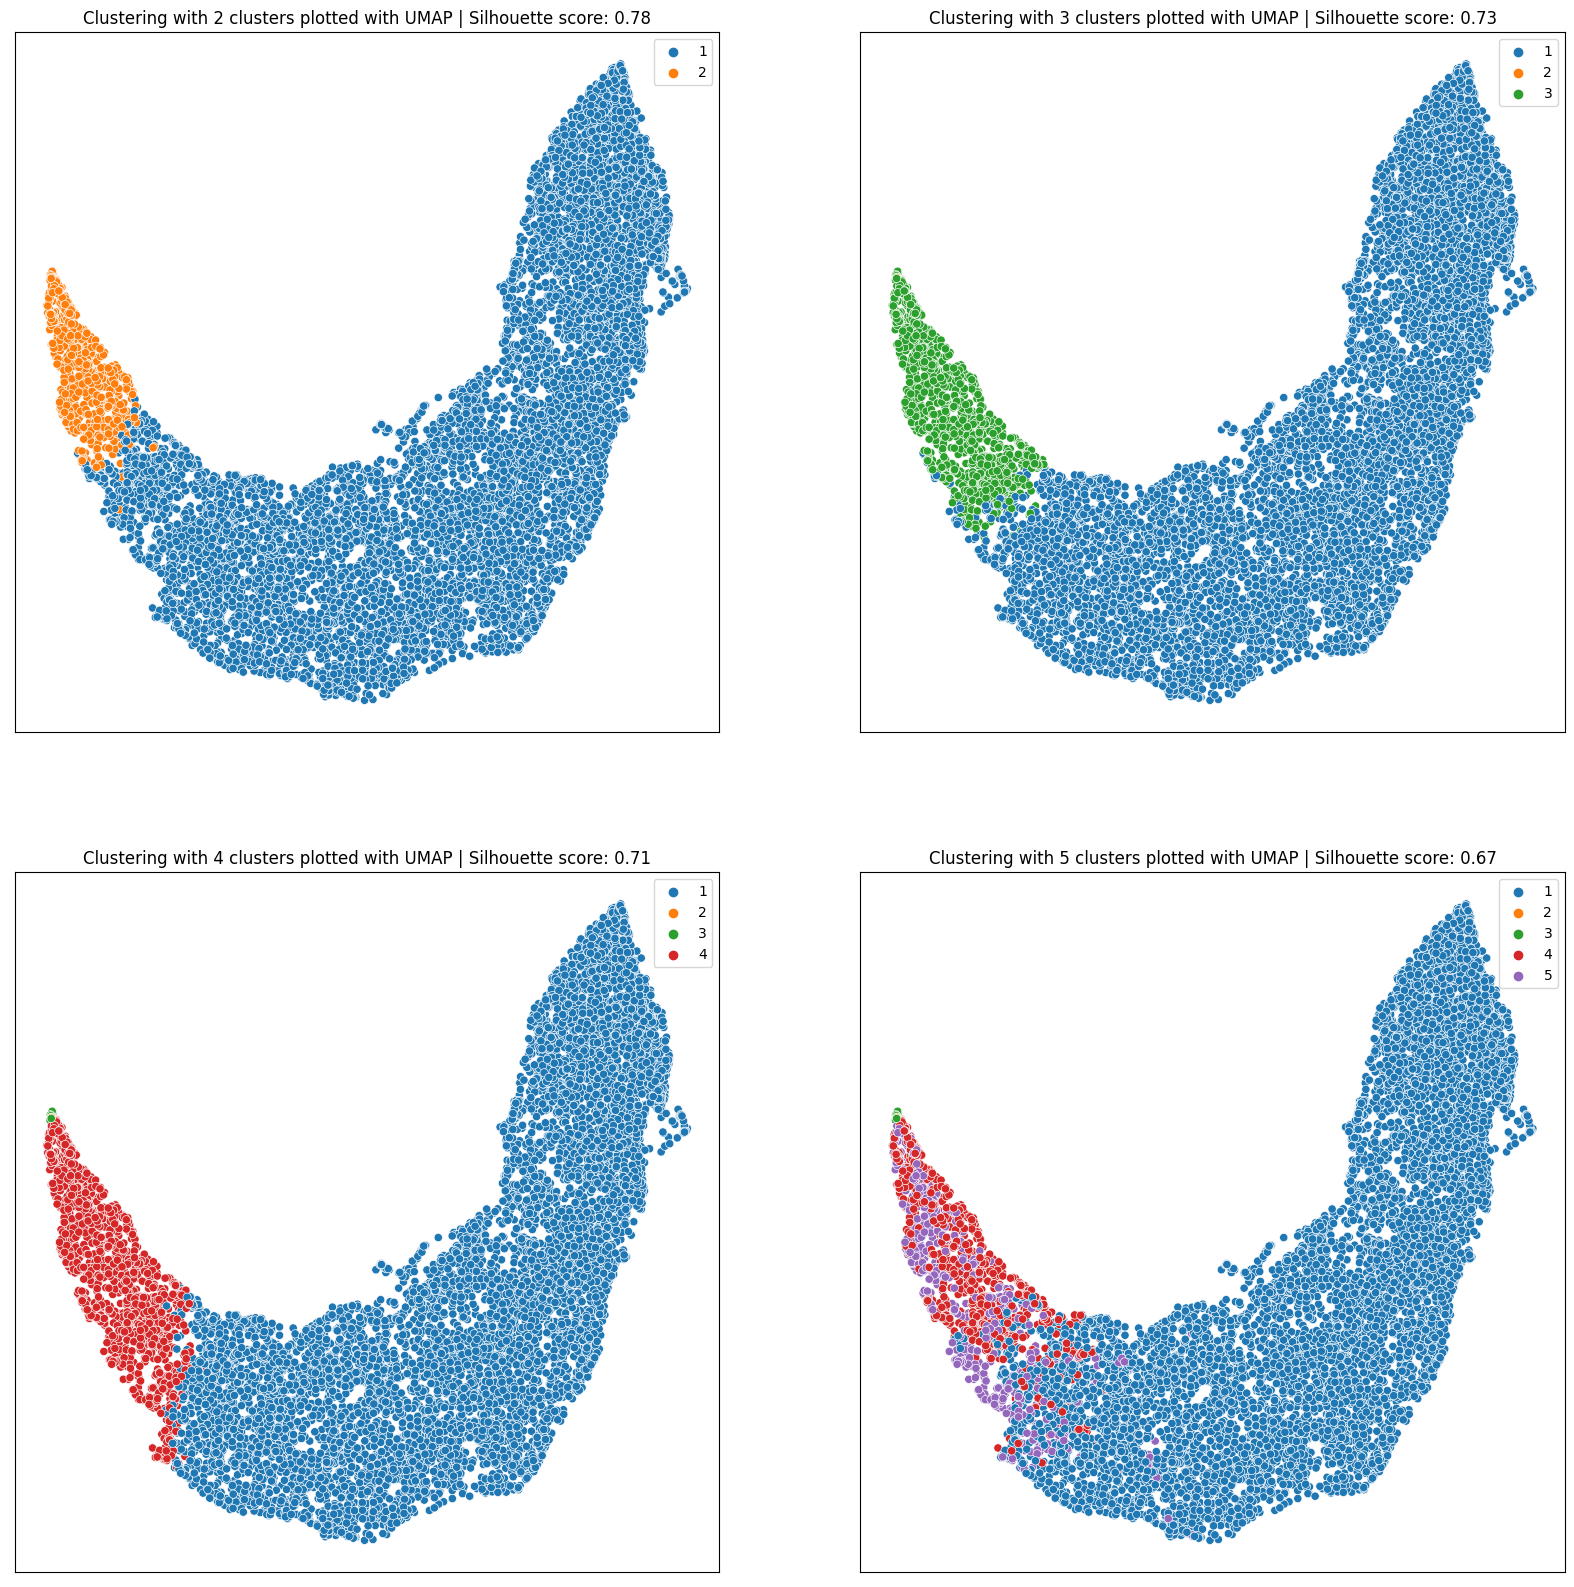

In [9]:
from umap import UMAP


embedding = UMAP().fit_transform(users_profiles)

# Plotting all the clustering using subplots and seaborn
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels[i]+1, ax=ax, palette='tab10')
    ax.set_title(f'Clustering with {i + 2} clusters plotted with UMAP | Silhouette score: {round(silhouette_scores[i], 2)}')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

Clusters seems very unbalanced, we can plot the number of users in each cluster to confirm this.

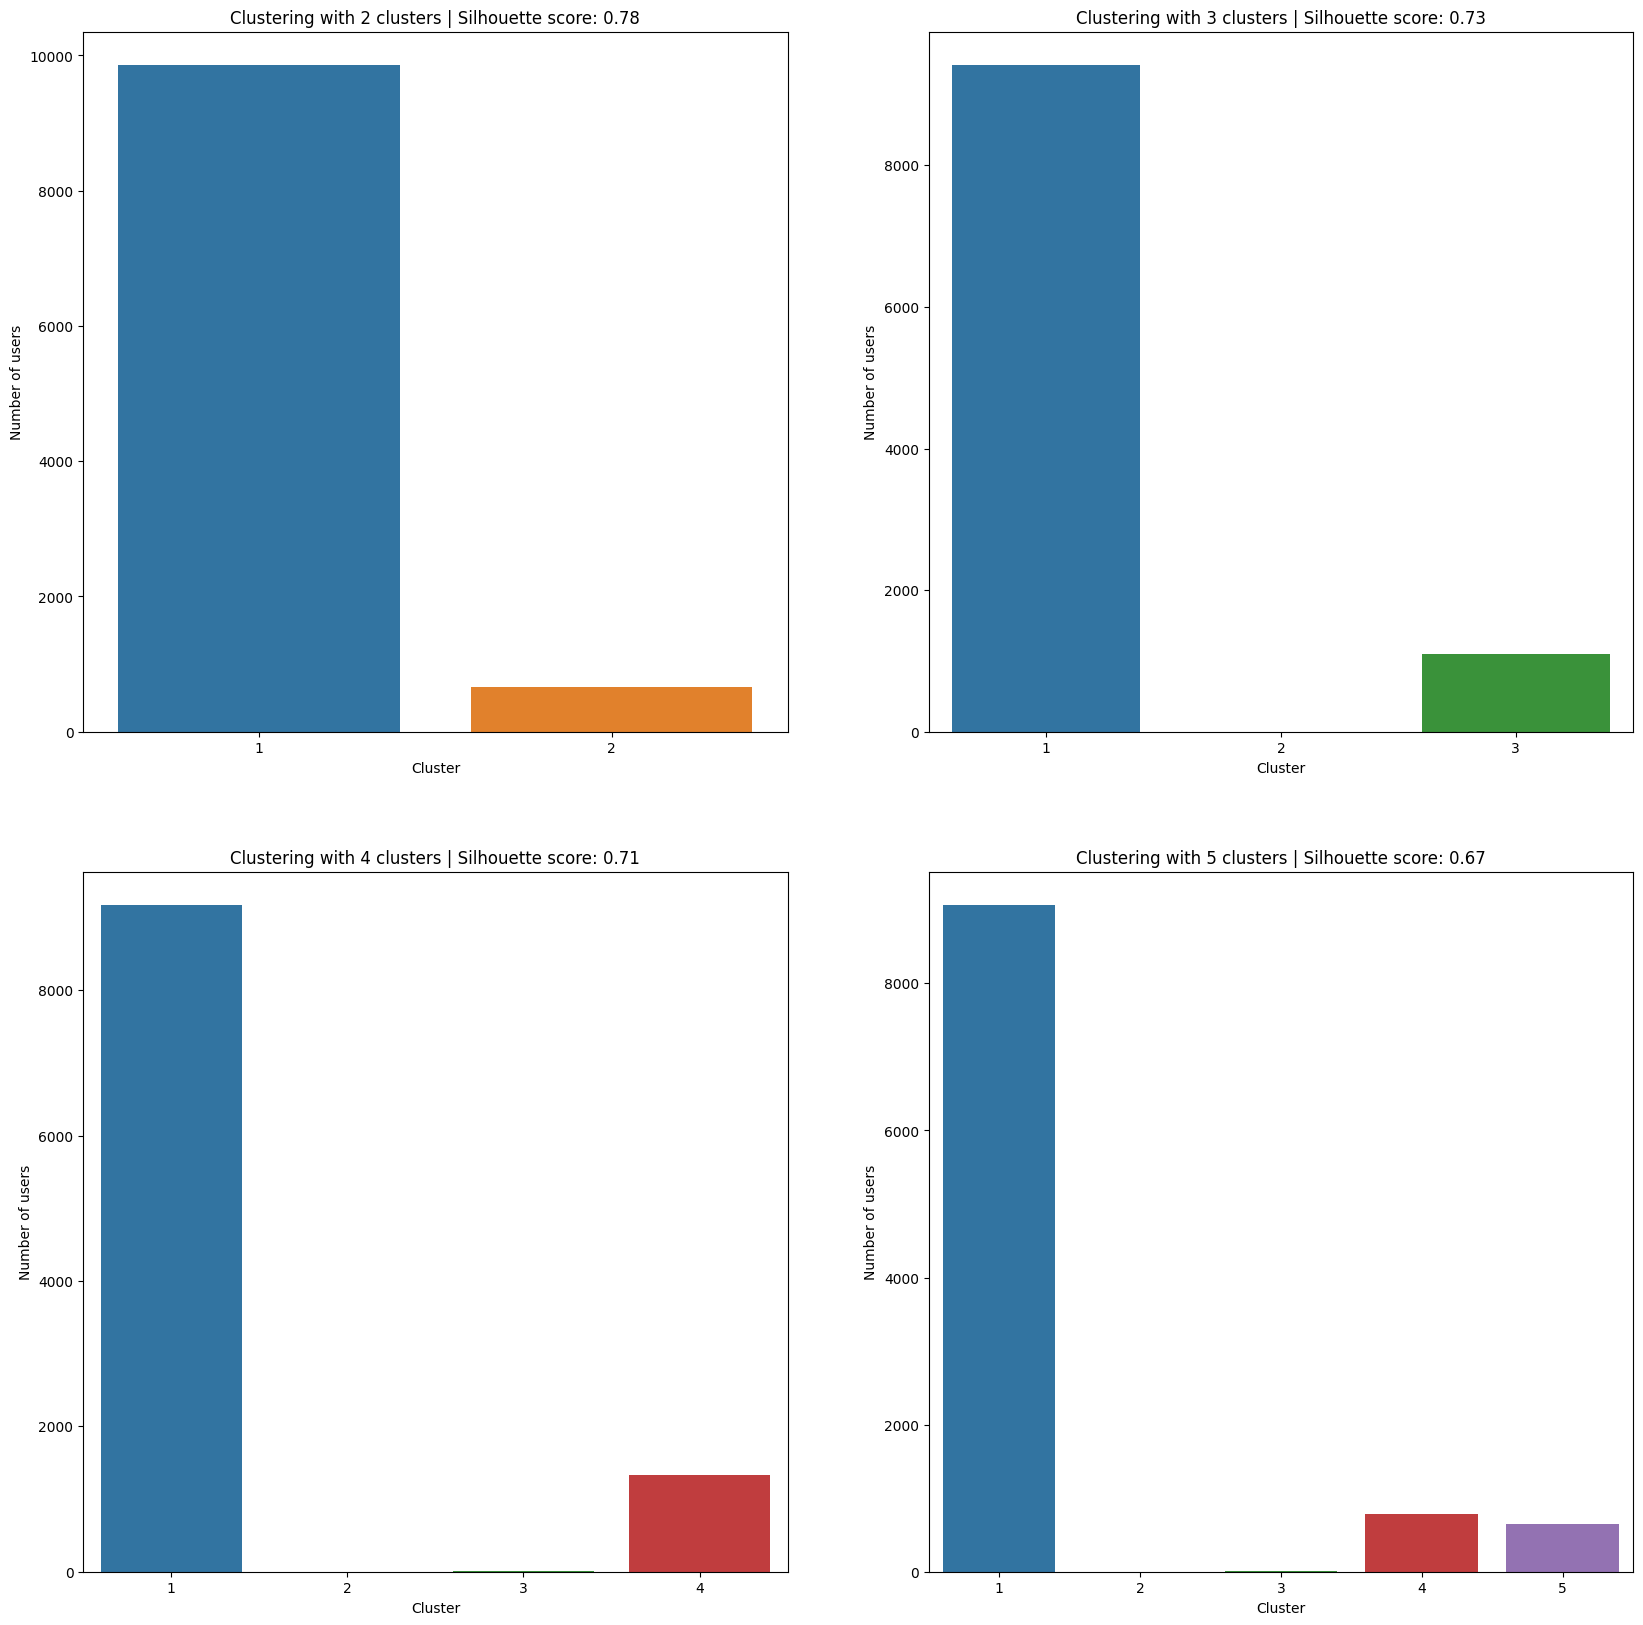

In [10]:
# Plotting the distribution between the clusters for each clsutering
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    sns.barplot(x=np.unique(labels[i], return_counts=True)[0]+1, y=np.unique(labels[i], return_counts=True)[1], ax=ax)
    ax.set_title(f'Clustering with {i + 2} clusters | Silhouette score: {round(silhouette_scores[i], 2)}')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of users')
plt.show()

### **Question 6**

We can use the `StratifiedShuffleSplit` function from `sklearn` to split the data into 3 separate files `ratings_train.csv`, `ratings_evaluation.csv` and `ratings_test.csv` containing respectively 60%, 20% and 20% of the ratings.

The function `StratifiedShuffleSplit` allows us to keep the same distribution of ratings in each file.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# 60% train, 40% eval_test
train_eval_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4)
train_eval_test_split.get_n_splits(ratings, ratings['rating'])
for train_eval_index, test_index in train_eval_test_split.split(ratings, ratings['rating']):
    train_set = ratings.iloc[train_eval_index]
    eval_test_set = ratings.iloc[test_index]

# 20% eval, 20% test
eval_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
eval_test_split.get_n_splits(eval_test_set, eval_test_set['rating'])
for eval_index, test_index in eval_test_split.split(eval_test_set, eval_test_set['rating']):
    eval_set = eval_test_set.iloc[eval_index]
    test_set = eval_test_set.iloc[test_index]

print(f'Train set size: {len(train_set)}')
print(f'Eval set size: {len(eval_set)}')
print(f'Test set size: {len(test_set)}')


Train set size: 941847
Eval set size: 313949
Test set size: 313950


We can now write the split data into the files.

In [12]:
# with open('data/ratings_train.csv', 'w', encoding='utf-8') as f:
#     f.write('userId,movieId,rating\n')
#     for _, rating in train_set.iterrows():
#         f.write(f'{rating["userId"]},{rating["movieId"]},{rating["rating"]}\n')

# with open('data/ratings_evaluation.csv', 'w', encoding='utf-8') as f:
#     f.write('userId,movieId,rating\n')
#     for _, rating in eval_set.iterrows():
#         f.write(f'{rating["userId"]},{rating["movieId"]},{rating["rating"]}\n')

# with open('data/ratings_test.csv', 'w', encoding='utf-8') as f:
#     f.write('userId,movieId,rating\n')
#     for _, rating in test_set.iterrows():
#         f.write(f'{rating["userId"]},{rating["movieId"]},{rating["rating"]}\n')

We choose `k = 2` for the clustering since it has the best silhouette score and store the `affinity_matrix` to try and find the most similar users.

In [13]:
clustering = SpectralClustering(n_clusters=2, assign_labels="kmeans", n_jobs=-1).fit(users_profiles)

affinity_matrix = clustering.affinity_matrix_
for i in range(len(affinity_matrix)):
    affinity_matrix[i, i] = 0

# Understanding the affinity matrix
closest_user = np.argmax(affinity_matrix[0])

print(f'First user profile: \n{[round(s*100, 2) for s in users_profiles[0]]}\n')
print(f'Closest user profile: \n{[round(s*100, 2) for s in users_profiles[closest_user]]}')

First user profile: 
[0.49, 0.1, 0.14, 1.05, 0.2, 0.89, 2.45, 0.2, 0.39, 0.26, 0.04, 0.16, 0.21, 0.0, 0.03, 0.24, 0.23, 0.03, 0.04]

Closest user profile: 
[0.35, 0.05, 0.09, 1.03, 0.11, 0.74, 2.55, 0.48, 0.44, 0.35, 0.11, 0.26, 0.18, 0.0, 0.19, 0.34, 0.16, 0.06, 0.05]


The closest user profile according to the affinity matrix is the user itself, so we need to remove the diagonal of the matrix before getting the closest users.

Then we can see that that users that have a high affinity with each other have indeed similar profiles, so we will use the affinity matrix to select the 5 closest users for each user.